# Import Library

In [1]:
import os, shutil
import tensorflow as tf
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import scipy
import keras
from PIL import Image
from scipy import ndimage
from keras.utils.np_utils import to_categorical  
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, array_to_img, load_img
from keras.layers import Dropout, Flatten, Dense  
from tensorflow.keras.applications import VGG16
from tensorflow.keras import callbacks, optimizers

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load Directory

In [4]:
train_data_dir = "/content/drive/MyDrive/Capstone C23-PC619/3. Dataset/Fauna/Animal Dataset/train"    
test_data_dir = "/content/drive/MyDrive/Capstone C23-PC619/3. Dataset/Fauna/Animal Dataset/test"
   
img_width, img_height = 224, 224   
epochs = 100  
batch_size = 50
animals = ['Spider', 'Snake', 'Sheep', 'Pig', 'Mouse', 'Monkey', 'Horse', 'Hamster', 'Frog', 'Fish', 'Duck', 'Chicken', 'Butterfly']

# Pra-Processing

In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_data_gen = datagen.flow_from_directory(
train_data_dir,
target_size=(img_width, img_height),
batch_size=batch_size,
class_mode='categorical',
shuffle=True,
classes = (animals))

nb_train_samples = len(train_data_gen.filenames)
num_classes = len(train_data_gen.class_indices)

predict_size_train = int(np.ceil(nb_train_samples / batch_size))

test_data_gen  = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode='categorical',  
     shuffle=True,
     classes = (animals))  

nb_test_samples = len(test_data_gen.filenames)  
predict_size_test = int(np.ceil(nb_test_samples / batch_size))

Found 0 images belonging to 13 classes.
Found 0 images belonging to 13 classes.


In [6]:
pre_model = VGG16(include_top=False, weights='imagenet')

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
pre_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [ ]:
features_train = pre_model.predict(train_data_gen, predict_size_train)
np.save('features_train.npy', features_train)

features_test = pre_model.predict(test_data_gen, predict_size_test)  
np.save('features_test.npy', features_test) 

 42/146 [=======>......................] - ETA: 58:28

In [ ]:
train_data = np.load('features_train.npy')  
# get the class lebels for the training data, in the original order  
train_labels = train_data_gen.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

test_data = np.load('features_test.npy')  
   
test_labels = test_data_gen.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

# Visualisasi

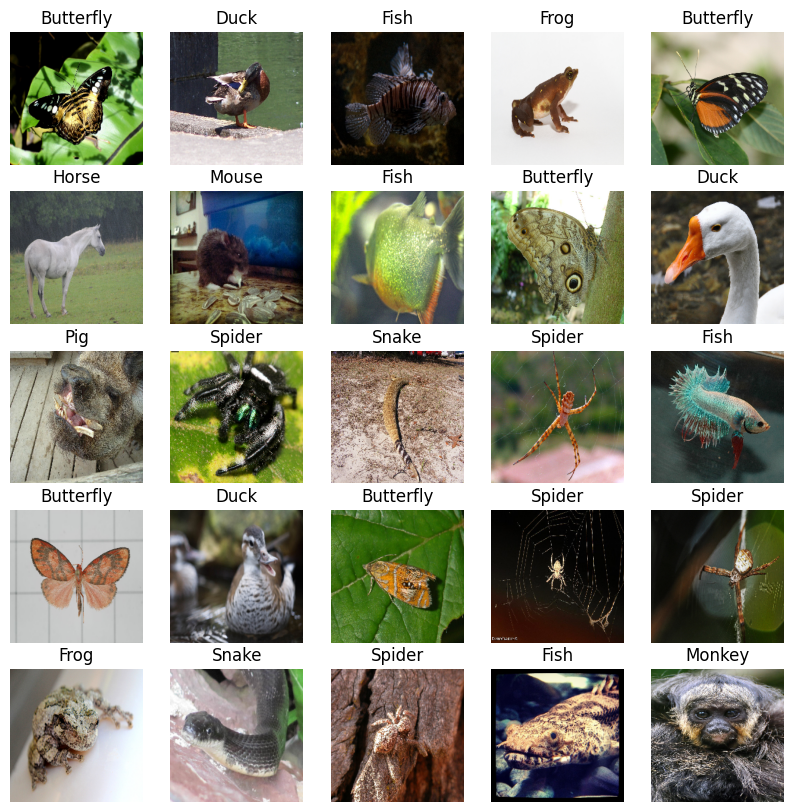

In [ ]:
import matplotlib.pyplot as plt

# You need to turn the classes into a numpy array
animal_np = np.array(animals)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(animal_np[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Modelling

In [ ]:
from keras import models
from keras import layers
from keras import optimizers


model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Flatten(input_shape=(img_width, img_height, 3)))
model.add(tf.keras.layers.Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(tf.keras.layers.Dropout(0.5))  
model.add(tf.keras.layers.Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3)))  
model.add(tf.keras.layers.Dropout(0.3)) 
model.add(tf.keras.layers.Dense(num_classes, activation='softmax'))      


In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [ ]:
Callbacks = callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
save_ck = callbacks.ModelCheckpoint('.mdl_fc.hdf5', save_best_only=True, monitor='val_loss', mode='min') 

history = model.fit(train_data, 
                    train_labels,
                    epochs=10,
                    batch_size=batch_size,
                    validation_data=(test_data, 
                                     test_labels),
                    callbacks=[callbacks, save_ck])

# Evaluasi


In [ ]:
eval_accuracy, eval_loss = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss)) 

In [ ]:
#Graphing our training and validation
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.ylabel('loss')  
plt.xlabel('epoch')
plt.legend()
plt.show()

# Testing

In [ ]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image...")  
    image = load_img(file_path, target_size=(224, 224))  
    image = img_to_array(image)  
    image = np.expand_dims(image, axis=0)
    image /= 255.  
    return image

In [ ]:
def test_single_image(path):
    animals = ['Spider', 'Snake', 'Sheep', 'Pig', 'Mouse', 'Monkey', 'Horse', 'Hamster', 'Frog', 'Fish', 'Duck', 'Chicken', 'Butterfly']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images)  
    preds = model.predict_proba(bt_prediction)
    for idx, animal, x in zip(range(0,6), animals , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_top.class_indices  
    inv_map = {v: k for k, v in class_dictionary.items()}  
    print("ID: {}, Label: {}".format(class_predicted[0], inv_map[class_predicted[0]]))  
    return load_img(path)

In [ ]:
path = ''

In [ ]:
test_single_image(path)